In [1]:
import nibabel as nib
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model, regularizers
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import cv2

In [2]:
def calculate_label(image, threshold=0.05):
    """
    Determina o label da subimagem com base no percentual de fundo não-preto.
    :param subimage: Array da subimagem.
    :param threshold: Percentual mínimo de fundo não-preto para considerar como label 1.
    :return: String indicando o label.
    """
    # Total de pixels na subimagem
    total_pixels = image.size
    # Número de pixels não-preto
    non_zero_pixels = np.count_nonzero(image)
    # Proporção de pixels não-preto
    non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
    
    # Verifica se há lesão e se o fundo não-preto é maior que o limiar
    if np.any(image == 1) and non_black_ratio >= threshold:
        return 1
    else:
        return 0

# Função que carrega os dados com pares de imagens
def load_data_with_pairs(folder):
    if not os.path.exists(folder):
        print(f"A pasta {folder} não existe.")
        return {}, {}, {}, {}, {}
    
    images_left = {}
    images_right = {}
    mask_left = {}
    mask_right = {}
    labels_left = {}
    labels_right = {}
    patient_ids = []

    # Itera sobre os pacientes no diretório
    for patient_id in tqdm(os.listdir(folder), desc="Carregamento de arquivos NIfTI..."):
        patient_path = os.path.join(folder, patient_id)

        areas_image = ["left", "right"]
        areas_mask = ["lesion_left", "lesion_right"]
        path_left = os.path.join(patient_path, areas_image[0])
        path_right = os.path.join(patient_path, areas_image[1])
        lesion_path_left = os.path.join(patient_path, areas_mask[0])
        lesion_path_right = os.path.join(patient_path, areas_mask[1])

        if patient_id not in images_left:
            images_left[patient_id] = []
        if patient_id not in images_right:
            images_right[patient_id] = []
        if patient_id not in mask_left:
            mask_left[patient_id] = []
        if patient_id not in mask_right:
            mask_right[patient_id] = []
        if patient_id not in labels_left:
            labels_left[patient_id] = []
        if patient_id not in labels_right:
            labels_right[patient_id] = []
                    
        # Carrega as imagens e máscaras do lado esquerdo
        for patch_id, mask_id in zip(os.listdir(path_left), os.listdir(lesion_path_left)):
            img_path= os.path.join(path_left, patch_id)
            mask_path = os.path.join(lesion_path_left, mask_id)
            for img_path_left, mask_path_left in zip(os.listdir(img_path), os.listdir(mask_path)):
                image_data_left = nib.load(os.path.join(img_path, img_path_left)).get_fdata()
                mask_data_left = nib.load(os.path.join(mask_path, mask_path_left)).get_fdata()

                if (len(image_data_left) > 0 and image_data_left is not []) or (len(mask_data_left) > 0 and mask_data_left is not []):
                    images_left[patient_id].append(image_data_left)
                    mask_left[patient_id].append(mask_data_left)

                    labels_left[patient_id].append(calculate_label(mask_data_left))

        # Carrega as imagens e máscaras do lado direito
        for patch_id, mask_id in zip(os.listdir(path_right), os.listdir(lesion_path_right)):
            img_path = os.path.join(path_right, patch_id)
            mask_path = os.path.join(lesion_path_right, mask_id)
            for img_path_right, mask_path_right in zip(os.listdir(img_path), os.listdir(mask_path)):
                image_data_right = nib.load(os.path.join(img_path, img_path_right)).get_fdata()
                mask_data_right = nib.load(os.path.join(mask_path, mask_path_right)).get_fdata()

                if (len(image_data_right) > 0 and image_data_right is not []) or (len(mask_data_right) > 0 and mask_data_right is not []):
                    images_right[patient_id].append(image_data_right)
                    mask_right[patient_id].append(mask_data_right)
                    
                    labels_right[patient_id].append(calculate_label(mask_data_right))
        patient_ids.append(patient_id)

    # Estruturas para armazenar os pares de labels
    labels_pair = {}
    for patient_id,_ in zip(labels_left.keys(), labels_right.keys()):
        labels_pair[patient_id] = []
        for label_left, label_right in zip(labels_left[patient_id], labels_right[patient_id]): 
            if label_left == 0 and label_right == 0:
                labels_pair[patient_id].append(0)
            else:
                labels_pair[patient_id].append(1)

    print(f"Total de pacientes: {len(patient_ids)}")
    for patient_id, labels in labels_pair.items():
        print(f"Paciente {patient_id}: Total de pares de recortes: {len(labels)}")

    return images_left, images_right, labels_pair, mask_left, mask_right

In [3]:
# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images_original, all_images_opposite, all_labels):
    selected_images_original = {}
    selected_images_opposite = {}
    selected_labels = []
    
    for patient in patients:
        selected_images_original[patient] = []
        selected_images_opposite[patient] = []
        if patient in all_images_original and patient in all_images_opposite:
            selected_images_original[patient].extend(all_images_original[patient])
            selected_images_opposite[patient].extend(all_images_opposite[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return selected_images_original, selected_images_opposite, selected_labels

In [4]:
# Função para preparar os dados para treino e validação
def prepare_data_for_training_balanced(images_left, images_right, labels_pair, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_original = {}
    balanced_images_opposite = {}
    balanced_labels = {}
    balanced_mask_original = {}
    balanced_mask_opposite = {}

    for patient_id in images_left:
        class_1_labels = []
        class_0_labels = []
        class_1_left = {}
        class_0_left = {}
        class_1_right = {}
        class_0_right = {}
        class_1_mask_left = {}
        class_0_mask_left = {}
        class_1_mask_right = {}
        class_0_mask_right = {}
        
        class_1_left[patient_id] = []
        class_0_left[patient_id] = []
        class_1_right[patient_id] = []
        class_0_right[patient_id] = []
        class_1_mask_left[patient_id] = []
        class_0_mask_left[patient_id] = []
        class_1_mask_right[patient_id] = []
        class_0_mask_right[patient_id] = []
        index = 0
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels\n",
        for label in labels_pair[patient_id]:
            image_left = (images_left[patient_id])[index]
            image_right = (images_right[patient_id])[index]
            mask_image_left = (mask_left[patient_id])[index]
            mask_image_right = (mask_right[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels.append(label)
                class_1_left[patient_id].append(image_left)
                class_1_right[patient_id].append(image_right)
                class_1_mask_left[patient_id].append(mask_image_left)
                class_1_mask_right[patient_id].append(mask_image_right)
            else:
                class_0_labels.append(label)
                class_0_left[patient_id].append(image_left)
                class_0_right[patient_id].append(image_right)
                class_0_mask_left[patient_id].append(mask_image_left)
                class_0_mask_right[patient_id].append(mask_image_right)
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com labels 1: {class_1_count}")

        # Fazer undersampling da classe majoritária (label 0) para igualar ao número de exemplos da classe 1\n",
        class_0_count = len(class_0_labels)
        if class_0_count > class_1_count:
            sampled_class_0_slices_left = (class_0_left[patient_id])[:class_1_count]
            sampled_class_0_slices_right = (class_0_right[patient_id])[:class_1_count]
            class_0_original_modified = {}
            class_0_original_modified[patient_id] = []
            class_0_opposite_modified = {}
            class_0_opposite_modified[patient_id] = []
            sampled_class_0_mask_left = (class_0_mask_left[patient_id])[:class_1_count]
            sampled_class_0_mask_right = (class_0_mask_right[patient_id])[:class_1_count]
            class_0_mask_original_modified = {}
            class_0_mask_original_modified[patient_id] = []
            class_0_mask_opposite_modified = {}
            class_0_mask_opposite_modified[patient_id] = []
            
            for left_image, left_mask in zip(sampled_class_0_slices_left, sampled_class_0_mask_left):
                class_0_original_modified[patient_id].append(left_image)
                class_0_mask_original_modified[patient_id].append(left_mask)
            for right_image, right_mask in zip(sampled_class_0_slices_right, sampled_class_0_mask_right):
                class_0_opposite_modified[patient_id].append(right_image)
                class_0_mask_opposite_modified[patient_id].append(right_mask)
            class_0_labels = [0] * class_1_count

        balanced_images_original[patient_id] = list(class_1_left[patient_id]) + list(class_0_original_modified[patient_id])
        balanced_images_opposite[patient_id] = list(class_1_right[patient_id]) + list(class_0_opposite_modified[patient_id])
        balanced_labels[patient_id] = class_1_labels + class_0_labels
        balanced_mask_original[patient_id] = list(class_1_mask_left[patient_id]) + list(class_0_mask_original_modified[patient_id])
        balanced_mask_opposite[patient_id] = list(class_1_mask_right[patient_id]) + list(class_0_mask_opposite_modified[patient_id])
    for patient_id, images in balanced_images_original.items():
        print(f"Paciente {patient_id}: Total de pares de recortes (label 1 + label 0): {len(images)}")
        
    # Separar os dados por conjunto (treino, validação, teste)
    patients = list(set(balanced_labels.keys()))
    train_patients, valtest_patients = train_test_split(patients, train_size = train_size)
    valid_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size))
    
    train_patients = ['sub-00H10', 'sub-02A13', 'sub-14F04', 'sub-16E03', 'sub-19G04', 'sub-25B08', 'sub-26B09', 'sub-31F07',  'sub-36K02', 'sub-42K06', 'sub-44H05', 'sub-51C05', 'sub-56E13', 'sub-59G00', 'sub-60G06', 'sub-60G13', 'sub-60K04', 'sub-71C07', 'sub-72I02', 'sub-72K02', 'sub-76E02', 'sub-79H07', 'sub-83K08', 'sub-85I05', 'sub-86B13']
    valid_patients = ['sub-03C08', 'sub-16G09', 'sub-19F09', 'sub-22F14', 'sub-35E12', 'sub-42B05', 'sub-57D04', 'sub-59E09']
    test_patients = ['sub-29D03', 'sub-34J06', 'sub-41D08', 'sub-76J09']
    
    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(valid_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    mask_test_original, mask_test_opposite, _ = select_by_patients(test_patients, balanced_mask_original, balanced_mask_opposite, balanced_labels)
    
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 0: {y_test.count(0)}")
    
    return X_train_original, X_train_opposite, X_val_original, X_val_opposite, np.array(y_train), np.array(y_val), train_patients, valid_patients, test_patients

# Função para preparar os dados para teste
def prepare_data_for_training_unbalanced(images_left, images_right, labels_pair, mask_left, mask_right, train_patients, valid_patients, test_patients, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_original = {}
    balanced_images_opposite = {}
    balanced_labels = {}
    balanced_mask_original = {}
    balanced_mask_opposite = {}

    for patient_id in images_left:
        # Lista para armazenar grupos de fatias
        groups = []  
        
        # Criar os grupos de 4 fatias
        for i in range(0, len(labels_pair[patient_id]), 8):
            group = {
                "labels": labels_pair[patient_id][i:i+8],
                "images_left": images_left[patient_id][i:i+8],
                "images_right": images_right[patient_id][i:i+8],
                "mask_left": mask_left[patient_id][i:i+8],
                "mask_right": mask_right[patient_id][i:i+8]
            }
            groups.append(group)

        balanced_images_original[patient_id] = []
        balanced_images_opposite[patient_id] = []
        balanced_labels[patient_id] = []
        balanced_mask_original[patient_id] = []
        balanced_mask_opposite[patient_id] = []
        
        for group in groups:
            balanced_images_original[patient_id].extend(group["images_left"])
            balanced_images_opposite[patient_id].extend(group["images_right"])
            balanced_labels[patient_id].extend(group["labels"])
            balanced_mask_original[patient_id].extend(group["mask_left"])
            balanced_mask_opposite[patient_id].extend(group["mask_right"])
    for patient_id, images in balanced_images_original.items():
        print(f"Paciente {patient_id}: Total de pares de recortes: {len(images)}")
        
    # Separar os dados por conjunto (treino, validação, teste)
    # patients = list(set(balanced_labels.keys()))
    # train_patients, valtest_patients = train_test_split(patients, train_size = train_size)
    # valid_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size))

    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(valid_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    mask_test_original, mask_test_opposite, _ = select_by_patients(test_patients, balanced_mask_original, balanced_mask_opposite, balanced_labels)

    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 0: {y_test.count(0)}")
    
    return X_train_original, X_train_opposite, X_val_original, X_val_opposite, X_test_original, X_test_opposite, np.array(y_train), np.array(y_val), np.array(y_test), mask_test_original, mask_test_opposite, balanced_images_original, balanced_images_opposite, balanced_mask_original, balanced_mask_opposite

In [36]:
# Função para construir o modelo CNN 2D
def build_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3,3), data_format="channels_last", activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(32, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(64, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2))) 
    model.add(layers.Dropout(0.5)) 
    
    model.add(layers.Conv2D(128, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2))) 
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Flatten())

    return model

In [6]:
# Função para construir a rede siamesa
def build_siamese_model(input_shape):
    input_original = Input(shape=input_shape)
    input_opposite = Input(shape=input_shape)

    # Criar a CNN base compartilhada
    cnn_base = build_cnn_model(input_shape)
    
    # Aplicar a mesma CNN base para ambas as entradas
    output_original = cnn_base(input_original)
    output_opposite = cnn_base(input_opposite)

    # Concatenar as duas saídas (Lado esquerdo + Contra-lateral)
    concatenated = layers.Concatenate()([output_original, output_opposite])
    concatenated = layers.BatchNormalization()(concatenated)
    
    output = layers.Dense(1, activation='sigmoid')(concatenated)
    
    siamese_model = Model(inputs=[input_original, input_opposite], outputs=output)
    siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")])

    return siamese_model

In [7]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [8]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


In [10]:
input_folder = 'Contralateral'

# Carregar os dados
X_left, X_right, y, mask_left, mask_right = load_data_with_pairs(input_folder)

Carregamento de arquivos NIfTI...: 100%|██████████| 37/37 [25:37<00:00, 41.55s/it]

Total de pacientes: 37
Paciente sub-00H10: Total de pares de recortes: 1512
Paciente sub-02A13: Total de pares de recortes: 1512
Paciente sub-03C08: Total de pares de recortes: 1512
Paciente sub-14F04: Total de pares de recortes: 1512
Paciente sub-16E03: Total de pares de recortes: 1512
Paciente sub-16G09: Total de pares de recortes: 1512
Paciente sub-19F09: Total de pares de recortes: 1512
Paciente sub-19G04: Total de pares de recortes: 1512
Paciente sub-22F14: Total de pares de recortes: 1512
Paciente sub-25B08: Total de pares de recortes: 1512
Paciente sub-26B09: Total de pares de recortes: 1512
Paciente sub-29D03: Total de pares de recortes: 1512
Paciente sub-31F07: Total de pares de recortes: 1512
Paciente sub-34J06: Total de pares de recortes: 1512
Paciente sub-35E12: Total de pares de recortes: 1512
Paciente sub-36K02: Total de pares de recortes: 1512
Paciente sub-41D08: Total de pares de recortes: 1512
Paciente sub-42B05: Total de pares de recortes: 1512
Paciente sub-42K06: Tot

In [37]:
# Preparar dados para treino e validação
X_train_left, X_train_right, X_valid_left, X_valid_right, y_train, y_valid, train_patients, valid_patients, test_patients = prepare_data_for_training_balanced(X_left, X_right, y, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1)

# Crio copias para o print em pdf
train_left = X_train_left
train_right = X_train_right
valid_left = X_valid_left
valid_right = X_valid_right

# Adiciono camada de cor
X_train_left = np.array([elemento for lista in X_train_left.values() for elemento in lista])
X_train_left = np.expand_dims(X_train_left, axis=-1)
X_train_right = np.array([elemento for lista in X_train_right.values() for elemento in lista])
X_train_right = np.expand_dims(X_train_right, axis=-1)
X_valid_left = np.array([elemento for lista in X_valid_left.values() for elemento in lista])
X_valid_left = np.expand_dims(X_valid_left, axis=-1)
X_valid_right = np.array([elemento for lista in X_valid_right.values() for elemento in lista])
X_valid_right = np.expand_dims(X_valid_right, axis=-1)

Paciente sub-00H10: Total de pares de recortes com labels 1: 1
Paciente sub-02A13: Total de pares de recortes com labels 1: 57
Paciente sub-03C08: Total de pares de recortes com labels 1: 35
Paciente sub-14F04: Total de pares de recortes com labels 1: 5
Paciente sub-16E03: Total de pares de recortes com labels 1: 59
Paciente sub-16G09: Total de pares de recortes com labels 1: 31
Paciente sub-19F09: Total de pares de recortes com labels 1: 83
Paciente sub-19G04: Total de pares de recortes com labels 1: 12
Paciente sub-22F14: Total de pares de recortes com labels 1: 21
Paciente sub-25B08: Total de pares de recortes com labels 1: 26
Paciente sub-26B09: Total de pares de recortes com labels 1: 85
Paciente sub-29D03: Total de pares de recortes com labels 1: 36
Paciente sub-31F07: Total de pares de recortes com labels 1: 16
Paciente sub-34J06: Total de pares de recortes com labels 1: 41
Paciente sub-35E12: Total de pares de recortes com labels 1: 26
Paciente sub-36K02: Total de pares de reco

In [38]:
# Construir e compilar o modelo CNN
input_shape = (X_train_left[0].shape)

siamese_model = build_siamese_model(input_shape)
siamese_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 50, 50, 1)]          0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 50, 50, 1)]          0         []                            
                                                                                                  
 sequential_3 (Sequential)   (None, 128)                  98112     ['input_7[0][0]',             
                                                                     'input_8[0][0]']             
                                                                                                  
 concatenate_3 (Concatenate  (None, 256)                  0         ['sequential_3[0][0]',  

In [ ]:
# Adicionar o callback EarlyStopping e low rate scheduler
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Salvar a melhor epoca
checkpoint = callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss',  save_best_only=True,  save_weights_only=True, mode='min')

# Treinamento do modelo siames
history = siamese_model.fit([X_train_left, X_train_right], y_train, validation_data=([X_valid_left, X_valid_right], y_valid), batch_size=128, epochs=150, callbacks=[checkpoint])

Epoch 1/150
16/16 [==============================] - 5s 125ms/step - loss: 0.8614 - accuracy: 0.4667 - precision: 0.4688 - recall: 0.5000 - val_loss: 0.6495 - val_accuracy: 0.7317 - val_precision: 0.6599 - val_recall: 0.9560
Epoch 2/150
16/16 [==============================] - 2s 94ms/step - loss: 0.7257 - accuracy: 0.6539 - precision: 0.6772 - recall: 0.5882 - val_loss: 0.5984 - val_accuracy: 0.7375 - val_precision: 0.6929 - val_recall: 0.8534
Epoch 3/150
16/16 [==============================] - 2s 105ms/step - loss: 0.6362 - accuracy: 0.6975 - precision: 0.7193 - recall: 0.6480 - val_loss: 0.5770 - val_accuracy: 0.7273 - val_precision: 0.7246 - val_recall: 0.7331
Epoch 4/150
16/16 [==============================] - 2s 105ms/step - loss: 0.5948 - accuracy: 0.7314 - precision: 0.7463 - recall: 0.7010 - val_loss: 0.5743 - val_accuracy: 0.7038 - val_precision: 0.7405 - val_recall: 0.6276
Epoch 5/150
16/16 [==============================] - 2s 99ms/step - loss: 0.5644 - accuracy: 0.7475 -

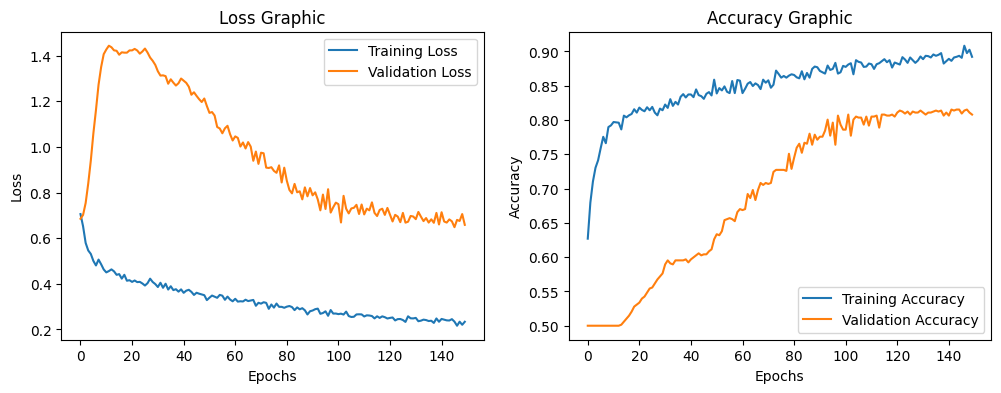

In [ ]:
# Plotar o histórico do treinamento
plot_training_history(history)

In [ ]:
# Preparar dados para teste e predição
X_train_left, X_train_right, X_valid_left, X_valid_right, X_test_left, X_test_right, y_train, y_valid, y_test, mask_left_test, mask_right_test, images_left_by_patient, images_right_by_patient, mask_left_by_patient, mask_right_by_patient = prepare_data_for_training_unbalanced(X_left, X_right, y, mask_left, mask_right, train_patients, valid_patients, test_patients, train_size=0.7, validation_size=0.2, test_size=0.1)

# Crio copias para o print em pdf
train_left = X_train_left
train_right = X_train_right
valid_left = X_valid_left
valid_right = X_valid_right
test_left = X_test_left
test_right = X_test_right

# Adiciono camada de cor
X_train_left = np.array([elemento for lista in X_train_left.values() for elemento in lista])
X_train_left = np.expand_dims(X_train_left, axis=-1)
X_train_right = np.array([elemento for lista in X_train_right.values() for elemento in lista])
X_train_right = np.expand_dims(X_train_right, axis=-1)
X_valid_left = np.array([elemento for lista in X_valid_left.values() for elemento in lista])
X_valid_left = np.expand_dims(X_valid_left, axis=-1)
X_valid_right = np.array([elemento for lista in X_valid_right.values() for elemento in lista])
X_valid_right = np.expand_dims(X_valid_right, axis=-1)
X_test_left = np.array([elemento for lista in X_test_left.values() for elemento in lista])
X_test_left = np.expand_dims(X_test_left, axis=-1)
X_test_right = np.array([elemento for lista in X_test_right.values() for elemento in lista])
X_test_right = np.expand_dims(X_test_right, axis=-1)

Paciente sub-00H10: Total de pares de recortes: 1512
Paciente sub-02A13: Total de pares de recortes: 1512
Paciente sub-03C08: Total de pares de recortes: 1512
Paciente sub-14F04: Total de pares de recortes: 1512
Paciente sub-16E03: Total de pares de recortes: 1512
Paciente sub-16G09: Total de pares de recortes: 1512
Paciente sub-19F09: Total de pares de recortes: 1512
Paciente sub-19G04: Total de pares de recortes: 1512
Paciente sub-22F14: Total de pares de recortes: 1512
Paciente sub-25B08: Total de pares de recortes: 1512
Paciente sub-26B09: Total de pares de recortes: 1512
Paciente sub-29D03: Total de pares de recortes: 1512
Paciente sub-31F07: Total de pares de recortes: 1512
Paciente sub-34J06: Total de pares de recortes: 1512
Paciente sub-35E12: Total de pares de recortes: 1512
Paciente sub-36K02: Total de pares de recortes: 1512
Paciente sub-41D08: Total de pares de recortes: 1512
Paciente sub-42B05: Total de pares de recortes: 1512
Paciente sub-42K06: Total de pares de recortes

189/189 [==============================] - 2s 10ms/step


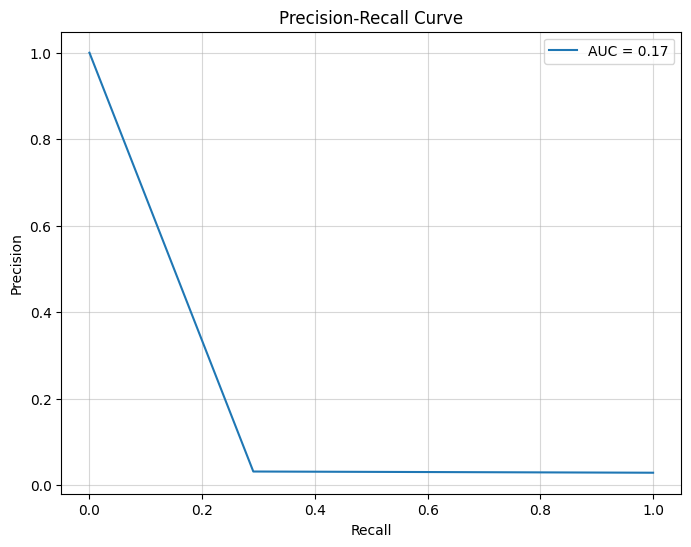

In [ ]:
# Carregando pesos da melhor época
siamese_model.load_weights('best_model.h5')

# Avaliar o modelo no treino
y_pred_train = (siamese_model.predict([X_train_left, X_train_right]) >=  0.5)

# Avaliar o modelo na validação
y_pred_valid = (siamese_model.predict([X_valid_left, X_valid_right]) >=  0.5)

# Avaliar o modelo no teste
y_pred = (siamese_model.predict([X_test_left, X_test_right]) >=  0.5)

# Calcule a curva precision-recall
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Calcule a AUC precision-recall
auc_pr = auc(recall, precision)

# Plote a curva precision-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(alpha=0.5)
plt.show()

In [34]:
# Gerar o relatório de classificação
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84      5876
           1       0.03      0.29      0.06       172

    accuracy                           0.72      6048
   macro avg       0.50      0.51      0.45      6048
weighted avg       0.95      0.72      0.82      6048



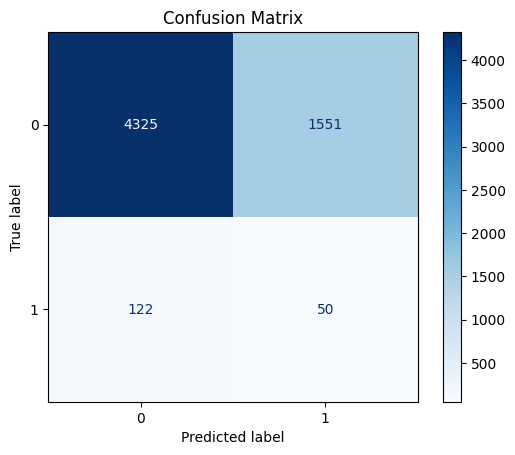

In [ ]:
# Gerar a matriz de confusão
plot_confusion_matrix(y_test, y_pred)

In [ ]:
def plot_classified_images_to_pdf(
    test_left, test_right, y_test, y_pred, mask_left_test, mask_right_test,
    condition, pdf_path, description):
    """
    Função genérica para plotar e salvar imagens classificadas em um PDF.

    Args:
        test_left (dict): Imagens MRI do lado esquerdo.
        test_right (dict): Imagens MRI do lado direito.
        y_test (list): Labels verdadeiros.
        y_pred (list): Labels preditos.
        mask_left_test (dict): Máscaras do lado esquerdo.
        mask_right_test (dict): Máscaras do lado direito.
        condition (callable): Função que define a condição para inclusão.
        pdf_path (str): Caminho do arquivo PDF para salvar as imagens.
        description (str): Descrição do conjunto de dados (e.g., "FN", "FP").
    """
    with PdfPages(pdf_path) as pdf:
        cont = 0
        for patient in test_left.keys():
            for i in range(len(test_left[patient])):
                label_pred = "Sim" if y_pred[cont] == 1 else "Não"
                label_verd = "Sim" if y_test[cont] == 1 else "Não"
                
                # Verificar condição de filtro
                if condition(label_verd, label_pred):
                    # Exibe progresso
                    print(f"Processando imagem {cont + 1} de {len(y_pred)} ({description})")

                    # Configuração da figura
                    fig, axs = plt.subplots(2, 2, figsize=(4, 4))

                    # Exibe as imagens
                    axs[0, 0].imshow(test_left[patient][i], cmap='gray')
                    axs[0, 0].set_title(f'{patient}-MRI E-{i}')
                    axs[0, 0].axis('off')

                    axs[1, 0].imshow(mask_left_test[patient][i], cmap='gray')
                    axs[1, 0].set_title(f'{patient}-Mask E-{i}')
                    axs[1, 0].axis('off')

                    axs[0, 1].imshow(test_right[patient][i], cmap='gray')
                    axs[0, 1].set_title(f'{patient}-MRI D-{i}')
                    axs[0, 1].axis('off')

                    axs[1, 1].imshow(mask_right_test[patient][i], cmap='gray')
                    axs[1, 1].set_title(f'{patient}-Mask D-{i}')
                    axs[1, 1].axis('off')

                    # Adiciona a figura atual ao PDF
                    pdf.savefig(fig)
                    plt.close(fig)

                cont += 1
        
        print(f"As imagens foram salvas no arquivo PDF '{pdf_path}' com sucesso.")

# Condições de Filtro
def condition_fn(label_verd, label_pred):
    return label_pred == "Não" and label_verd == "Sim"

def condition_fp(label_verd, label_pred):
    return label_pred == "Sim" and label_verd == "Não"

def condition_tn(label_verd, label_pred):
    return label_pred == "Não" and label_verd == "Não"

def condition_tp(label_verd, label_pred):
    return label_pred == "Sim" and label_verd == "Sim"

# Chamada das Funções
plot_classified_images_to_pdf(
    test_left, test_right, y_test, y_pred, mask_left_test, mask_right_test,
    condition_fn, 'Pdf_SNN/Pacientes_Conjunto_Teste_FN.pdf', 'FN')

plot_classified_images_to_pdf(
    test_left, test_right, y_test, y_pred, mask_left_test, mask_right_test,
    condition_fp, 'Pdf_SNN/Pacientes_Conjunto_Teste_FP.pdf', 'FP')

plot_classified_images_to_pdf(
    test_left, test_right, y_test, y_pred, mask_left_test, mask_right_test,
    condition_tn, 'Pdf_SNN/Pacientes_Conjunto_Teste_TN.pdf', 'TN')

plot_classified_images_to_pdf(
    test_left, test_right, y_test, y_pred, mask_left_test, mask_right_test,
    condition_tp, 'Pdf_SNN/Pacientes_Conjunto_Teste_TP.pdf', 'TP')

Processando imagem 1119 de 6048 (FN)
Processando imagem 1127 de 6048 (FN)
Processando imagem 1135 de 6048 (FN)
Processando imagem 1143 de 6048 (FN)
Processando imagem 1151 de 6048 (FN)
Processando imagem 1159 de 6048 (FN)
Processando imagem 1175 de 6048 (FN)
Processando imagem 1183 de 6048 (FN)
Processando imagem 1191 de 6048 (FN)
Processando imagem 1199 de 6048 (FN)
Processando imagem 1207 de 6048 (FN)
Processando imagem 1215 de 6048 (FN)
Processando imagem 1223 de 6048 (FN)
Processando imagem 1231 de 6048 (FN)
Processando imagem 1239 de 6048 (FN)
Processando imagem 1247 de 6048 (FN)
Processando imagem 1263 de 6048 (FN)
Processando imagem 1271 de 6048 (FN)
Processando imagem 1279 de 6048 (FN)
Processando imagem 1287 de 6048 (FN)
Processando imagem 1295 de 6048 (FN)
Processando imagem 1303 de 6048 (FN)
Processando imagem 1311 de 6048 (FN)
Processando imagem 1319 de 6048 (FN)
Processando imagem 1327 de 6048 (FN)
Processando imagem 1335 de 6048 (FN)
Processando imagem 1351 de 6048 (FN)
P

In [19]:
def add_border(image, color, thickness=3):
    """
    Adiciona uma borda colorida ao redor de uma imagem, convertendo para RGB se necessário.
    
    Args:
        image (numpy.ndarray): Imagem original em escala de cinza.
        color (tuple): Cor da borda (RGB).
        thickness (int): Espessura da borda.

    Returns:
        numpy.ndarray: Imagem com a borda adicionada em formato RGB.
    """
    # Normalizar a imagem para o intervalo 0-255
    image_normalized = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Converter para RGB
    if len(image_normalized.shape) == 2:  # Se a imagem for escala de cinza
        image_rgb = cv2.cvtColor(image_normalized, cv2.COLOR_GRAY2RGB)
    else:
        image_rgb = image_normalized

    # Adicionar a borda
    bordered_image = cv2.copyMakeBorder(
        image_rgb, 
        thickness, thickness, thickness, thickness, 
        cv2.BORDER_CONSTANT, 
        value=color
    )
    
    return bordered_image


def build_image(img, mask, classificacao):
    # Tamanho dos patches
    patch_size = 56

    # Inicializar a matriz para a imagem e a máscara reconstruídas
    imagem_reconstruida = np.zeros((4 * patch_size, 4 * patch_size, 3), dtype=np.uint8)
    mascara_reconstruida = np.zeros((4 * patch_size, 4 * patch_size, 3), dtype=np.uint8)

    # Mapear os patches para as posições corretas na matriz com bordas baseadas na classificação
    colors = {"TP": (0, 255, 0), "TN": (0, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}  # RGB: Vermelho, Verde, Azul

    # Ordem correta para reconstrução
    correct_order = [
        0, 1, 8, 9,    # Linha 1
        2, 3, 10, 11,   # Linha 2
        4, 5, 12, 13,  # Linha 3
        6, 7, 14, 15   # Linha 4
    ]
    correct_order_classification = [
        0, 1, 1, 0,    # Linha 1
        2, 3, 3, 2,    # Linha 2
        4, 5, 5, 4,    # Linha 3
        6, 7, 7, 6     # Linha 4
    ]

    # Loop para reconstruir as linhas e colunas
    for i in range(4):  # Linha
        for j in range(4):  # Coluna
            idx = correct_order[i * 4 + j]
            idx_classification = correct_order_classification[i * 4 + j]
            x_start = i * patch_size
            y_start = j * patch_size
            
            # Adicionar bordas às imagens
            imagem_reconstruida[x_start:x_start + patch_size, y_start:y_start + patch_size, :] = add_border(img[idx], colors[classificacao[idx_classification]])
            mascara_reconstruida[x_start:x_start + patch_size, y_start:y_start + patch_size, :] = add_border(mask[idx], colors[classificacao[idx_classification]])
    
    return imagem_reconstruida, mascara_reconstruida


In [20]:
def plot_patient_slices(pdf_filename, patients, images_left, images_right, mask_left, mask_right, labels_true, labels_pred):
    """
    Gera um PDF com imagens de pacientes e suas máscaras.

    Args:
        pdf_filename (str): Nome do arquivo PDF.
        patients (list): Lista de IDs dos pacientes.
        images_dict (dict): Dicionário com imagens completas dos pacientes.
        masks_dict (dict): Dicionário com máscaras completas dos pacientes.
        labels_true (list): Labels verdadeiros das fatias.
        labels_pred (list): Labels preditos das fatias.
        slice_limits (list): Limites de fatias por paciente.
        non_black_threshold (float): Limite para considerar pixels não pretos.
        min_percentage_non_black (float): Porcentagem mínima de pixels não pretos para exibir.
    """
    with PdfPages(pdf_filename) as pdf:
        for patient in patients:
            cont = 0            
            
            classificacao = []
            vetor_left_img = []
            vetor_left_mask = []
            vetor_right_img = []
            vetor_right_mask = []
            tmp_vetor_left_img = []
            tmp_vetor_left_mask = []
            tmp_vetor_right_img = []
            tmp_vetor_right_mask = []
            tmp_classificacao = []
            
            for img_left, img_right, msk_left, msk_right in zip(images_left[patient], images_right[patient], mask_left[patient], mask_right[patient]):
                tmp_vetor_left_img.append(img_left)
                tmp_vetor_left_mask.append(msk_left)
                tmp_vetor_right_img.append(np.fliplr(img_right))
                tmp_vetor_right_mask.append(np.fliplr(msk_right))
                if labels_pred[cont] == 1:
                    if labels_true[cont] == 1:
                        tmp_classificacao.append("TP")
                    else:
                        if (calculate_label(msk_left) or calculate_label(msk_right)):
                            tmp_classificacao.append("TP")
                        else:
                            tmp_classificacao.append("FP")
                elif labels_pred[cont] == 0:
                    if labels_true[cont] == 1:
                        if (calculate_label(msk_left) or calculate_label(msk_right)):
                            tmp_classificacao.append("FN")
                        else:
                            tmp_classificacao.append("TN")
                    else:
                        tmp_classificacao.append("TN")
                
                cont+=1
                if cont%8 ==0:
                    vetor_left_img.append(tmp_vetor_left_img)
                    vetor_left_mask.append(tmp_vetor_left_mask)
                    vetor_right_img.append(tmp_vetor_right_img)
                    vetor_right_mask.append(tmp_vetor_right_mask)
                    classificacao.append(tmp_classificacao)
                    tmp_vetor_left_img = []
                    tmp_vetor_left_mask = []
                    tmp_vetor_right_img = []
                    tmp_vetor_right_mask = []
                    tmp_classificacao = []
            
            cont = 0
            for i in range(len(vetor_left_img)):
                imagem_reconstruida, mascara_reconstruida = build_image(vetor_left_img[i]+vetor_right_img[i], vetor_left_mask[i]+vetor_right_mask[i], classificacao[i])
                 if (np.any(imagem_reconstruida) == 1):    
                    # Configurar a figura
                    fig, axs = plt.subplots(2, 1, figsize=(4, 4))

                    axs[0].imshow(np.flipud(imagem_reconstruida), cmap='gray')
                    axs[0].set_title(f'{patient}')
                    axs[0].axis('off')
                    axs[1].imshow(np.flipud(mascara_reconstruida), cmap='gray')
                    axs[1].axis('off')
                    
                    # Adicionar ao PDF
                    pdf.savefig(fig)
                    plt.close(fig)
        
        print(f"As imagens foram salvas no arquivo PDF {pdf_filename} com sucesso.")

# Processar Treino
plot_patient_slices(
    pdf_filename="Pdf_SNN/Pacientes_Train_Reconstruidos.pdf",
    patients=train_patients,
    images_left=images_left_by_patient,
    images_right=images_right_by_patient,
    mask_left=mask_left_by_patient,
    mask_right=mask_right_by_patient,
    labels_true=y_train,
    labels_pred=y_pred_train
)

# Processar Validação
plot_patient_slices(
    pdf_filename="Pdf_SNN/Pacientes_Valid_Reconstruidos.pdf",
    patients=valid_patients,
    images_left=images_left_by_patient,
    images_right=images_right_by_patient,
    mask_left=mask_left_by_patient,
    mask_right=mask_right_by_patient,
    labels_true=y_valid,
    labels_pred=y_pred_valid
)

# Processar Teste
plot_patient_slices(
    pdf_filename="Pdf_SNN/Pacientes_Test_Reconstruidos.pdf",
    patients=test_patients,
    images_left=images_left_by_patient,
    images_right=images_right_by_patient,
    mask_left=mask_left_by_patient,
    mask_right=mask_right_by_patient,
    labels_true=y_test,
    labels_pred=y_pred
)

IndentationError: unexpected indent (3398933250.py, line 69)